In [2]:
import pandas as pd

# Import data
data = pd.read_csv('D:\\Kpop-lyric-datasets\\songs_sample_10~24.csv')

df = pd.DataFrame(data)
df['text'] = df['Line']
df = df[['text', 'Song Name']]

print(df.head())

           text     Song Name
0   맨 처음 그 날의 난  우리 사랑하게 됐어요.
1  아마 몰랐겠지 이런 날  우리 사랑하게 됐어요.
2  어색했었던 우리 모습이  우리 사랑하게 됐어요.
3       어제만 같은데  우리 사랑하게 됐어요.
4      기억하고 있을까  우리 사랑하게 됐어요.


In [3]:
from transformers import BertTokenizer, BertModel
import torch

# BERT model % tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().detach().numpy()
    return embeddings[0]

# Data embedding
df['embedding'] = df['text'].astype(str).apply(get_bert_embeddings)

c:\Users\co279\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\co279\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\co279\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [11]:
# LSTM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM model
class LyricsClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LyricsClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_length, input_dim)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_L = LyricsClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_L.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_L.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_L(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_L.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_L(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_L.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_L(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 6.3257082806565474, Train Accuracy: 14.67%, Val Loss: 5.405220963011977, Val Accuracy: 24.71%
Epoch 2/10, Train Loss: 4.826269367564404, Train Accuracy: 31.25%, Val Loss: 4.71378094957829, Val Accuracy: 34.10%
Epoch 3/10, Train Loss: 4.209451839000067, Train Accuracy: 38.87%, Val Loss: 4.3832837534822255, Val Accuracy: 38.74%
Epoch 4/10, Train Loss: 3.8544357332221484, Train Accuracy: 43.50%, Val Loss: 4.1884526002597005, Val Accuracy: 41.83%
Epoch 5/10, Train Loss: 3.616628402924698, Train Accuracy: 46.67%, Val Loss: 4.04332191416786, Val Accuracy: 44.20%
Epoch 6/10, Train Loss: 3.4427865011823506, Train Accuracy: 49.00%, Val Loss: 3.9473153790136086, Val Accuracy: 46.06%
Epoch 7/10, Train Loss: 3.3077693929619083, Train Accuracy: 50.85%, Val Loss: 3.8743059335463275, Val Accuracy: 47.23%
Epoch 8/10, Train Loss: 3.198815982570679, Train Accuracy: 52.33%, Val Loss: 3.794481960237864, Val Accuracy: 48.59%
Epoch 9/10, Train Loss: 3.10913172910102, Train Accuracy: 

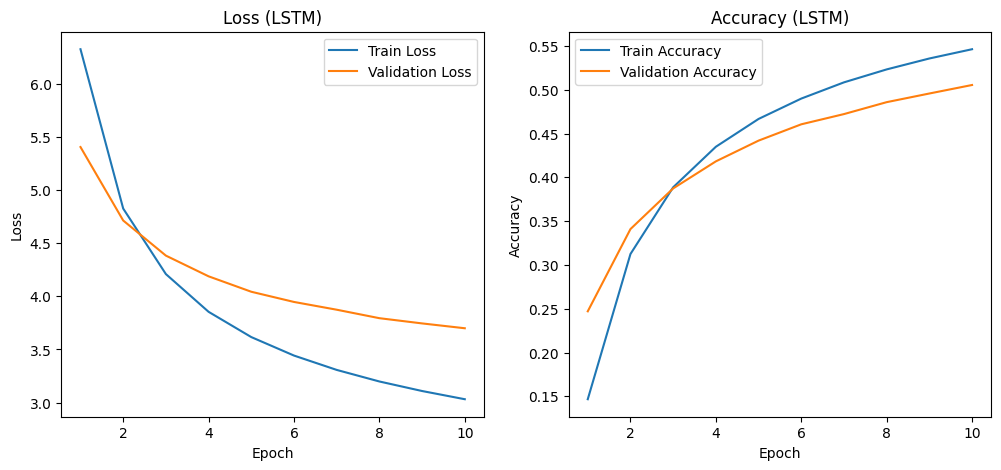

In [12]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (LSTM)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (LSTM)')
plt.legend()

plt.show()

In [13]:
# Transformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

# Data split (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer model
class LyricsTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, dropout=0.1):
        super(LyricsTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_length, input_dim)
        transformer_out = self.transformer_encoder(x)
        out = self.fc(transformer_out[:, 0, :])
        return out

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)
num_heads = 8
num_layers = 2

model_T = LyricsTransformer(input_dim, hidden_dim, output_dim, num_heads, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_T.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_T.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_T(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_T.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_T(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_T.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_T(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

c:\Users\co279\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Train Loss: 7.997605578923568, Train Accuracy: 0.68%, Val Loss: 7.977368134924935, Val Accuracy: 0.70%
Epoch 2/10, Train Loss: 7.9569162415179475, Train Accuracy: 0.69%, Val Loss: 7.955753139502106, Val Accuracy: 0.70%
Epoch 3/10, Train Loss: 7.954106106604392, Train Accuracy: 0.70%, Val Loss: 7.953958878700378, Val Accuracy: 0.70%
Epoch 4/10, Train Loss: 7.953631533381091, Train Accuracy: 0.70%, Val Loss: 7.95323776271484, Val Accuracy: 0.70%
Epoch 5/10, Train Loss: 7.953264786941622, Train Accuracy: 0.70%, Val Loss: 7.9566209012364935, Val Accuracy: 0.70%
Epoch 6/10, Train Loss: 7.953276332559458, Train Accuracy: 0.70%, Val Loss: 7.9538553452648175, Val Accuracy: 0.70%
Epoch 7/10, Train Loss: 7.953502678878338, Train Accuracy: 0.70%, Val Loss: 7.96774546554855, Val Accuracy: 0.70%
Epoch 8/10, Train Loss: 7.953191001575443, Train Accuracy: 0.70%, Val Loss: 7.957132335120311, Val Accuracy: 0.70%
Epoch 9/10, Train Loss: 7.953867122975413, Train Accuracy: 0.70%, Val Loss: 7.9

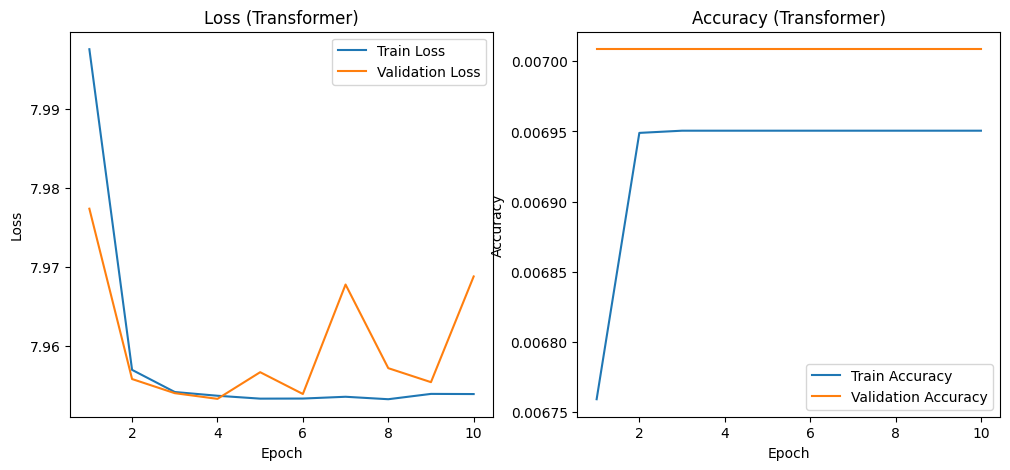

In [14]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Transformer)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (Transformer)')
plt.legend()

plt.show()

In [19]:
# CNN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

# Data split (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# CNN model
class LyricsCNN(nn.Module):
    def __init__(self, input_dim, num_filters, filter_sizes, output_dim):
        super(LyricsCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, 1)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(3)  # (batch_size, 1, seq_length, input_dim, 1)
        conved = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        return self.fc(cat)

# Hyper-parameters
input_dim = X_train.shape[1]
num_filters = 100
filter_sizes = [2, 3, 4]
output_dim = len(label_encoder.classes_)

# Loss function, optimizer
model_C = LyricsCNN(input_dim, num_filters, filter_sizes, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_C.parameters(), lr=0.001)

# Data loader
train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_C.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_C(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_C.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_C(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_C.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_C(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 7.706316563646586, Train Accuracy: 1.88%, Val Loss: 7.441981012394413, Val Accuracy: 3.04%
Epoch 2/10, Train Loss: 7.240892685380365, Train Accuracy: 4.43%, Val Loss: 7.193870559181135, Val Accuracy: 5.43%
Epoch 3/10, Train Loss: 6.9891029984953175, Train Accuracy: 6.61%, Val Loss: 7.039017041040115, Val Accuracy: 7.30%
Epoch 4/10, Train Loss: 6.803815064401982, Train Accuracy: 8.49%, Val Loss: 6.9253049378319105, Val Accuracy: 9.03%
Epoch 5/10, Train Loss: 6.652311175346279, Train Accuracy: 10.09%, Val Loss: 6.838397200127685, Val Accuracy: 10.31%
Epoch 6/10, Train Loss: 6.52644192651655, Train Accuracy: 11.45%, Val Loss: 6.753806973352763, Val Accuracy: 11.40%
Epoch 7/10, Train Loss: 6.417179382947646, Train Accuracy: 12.63%, Val Loss: 6.692865449352139, Val Accuracy: 12.38%
Epoch 8/10, Train Loss: 6.322739768576521, Train Accuracy: 13.73%, Val Loss: 6.643005140160665, Val Accuracy: 13.21%
Epoch 9/10, Train Loss: 6.241220656175911, Train Accuracy: 14.67%, Val 

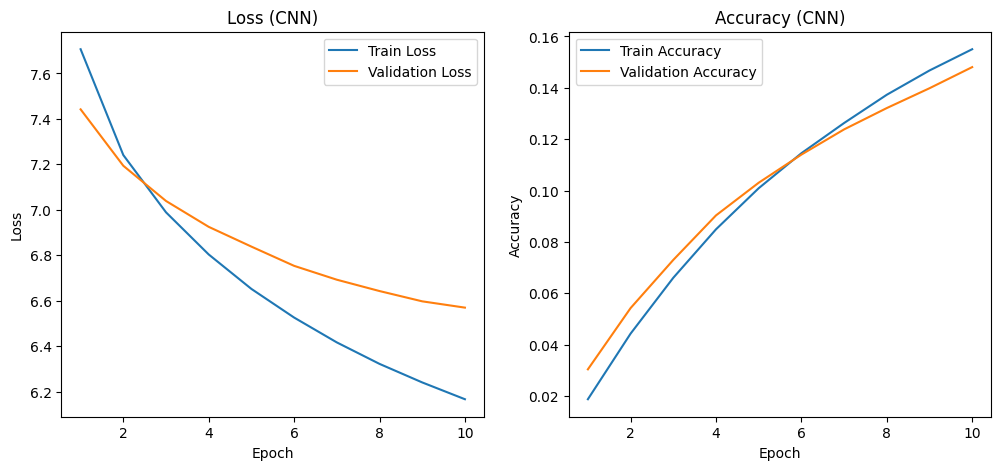

In [20]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (CNN)')
plt.legend()

# 학습 및 검증 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (CNN)')
plt.legend()

plt.show()

In [21]:
# GRU

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

# Data split (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# GRU model
class LyricsGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LyricsGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_length, input_dim)
        gru_out, _ = self.gru(x)
        gru_out = gru_out[:, -1, :]
        out = self.fc(gru_out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_G = LyricsGRU(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_G.parameters(), lr=0.001)

# Data loader
train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_G.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_G(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_G.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_G(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_G.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_G(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 6.128023995181769, Train Accuracy: 17.07%, Val Loss: 5.170247827776146, Val Accuracy: 27.87%
Epoch 2/10, Train Loss: 4.623129145883826, Train Accuracy: 33.87%, Val Loss: 4.55483281076122, Val Accuracy: 36.32%
Epoch 3/10, Train Loss: 4.048664012084084, Train Accuracy: 41.04%, Val Loss: 4.230236177117107, Val Accuracy: 41.04%
Epoch 4/10, Train Loss: 3.720013358272845, Train Accuracy: 45.31%, Val Loss: 4.06029648946174, Val Accuracy: 43.76%
Epoch 5/10, Train Loss: 3.5001919321641752, Train Accuracy: 48.23%, Val Loss: 3.925306943162312, Val Accuracy: 46.00%
Epoch 6/10, Train Loss: 3.335987222743008, Train Accuracy: 50.42%, Val Loss: 3.8440429314258733, Val Accuracy: 47.22%
Epoch 7/10, Train Loss: 3.208878488261453, Train Accuracy: 52.15%, Val Loss: 3.750988931043358, Val Accuracy: 48.88%
Epoch 8/10, Train Loss: 3.1046047683663427, Train Accuracy: 53.47%, Val Loss: 3.676998352686043, Val Accuracy: 50.25%
Epoch 9/10, Train Loss: 3.0182451364272143, Train Accuracy: 54.

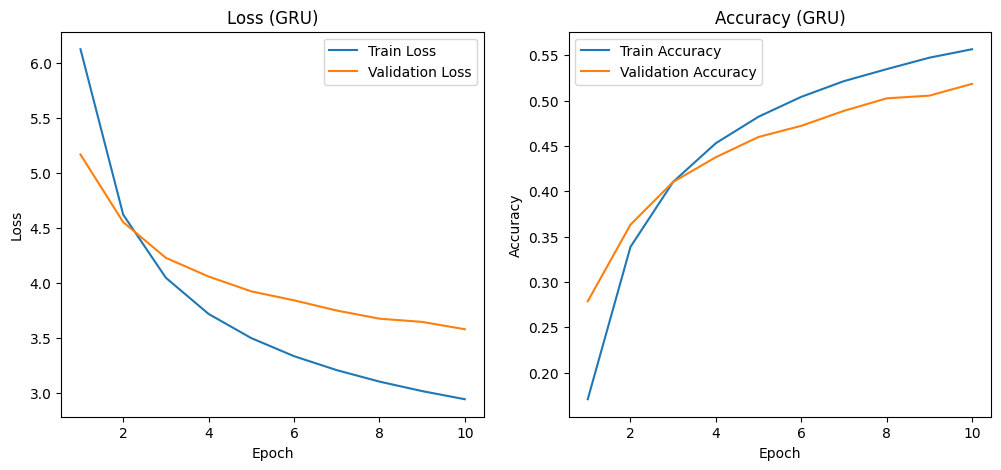

In [22]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (GRU)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (GRU)')
plt.legend()

plt.show()

In [23]:
# BiLSTM

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Song Name'])

X = np.vstack(df['embedding'].values)
y = df['label'].values

# Data split (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

train_dataset = LyricsDataset(X_train, y_train)
val_dataset = LyricsDataset(X_val, y_val)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# BiLSTM model
class LyricsBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LyricsBiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional LSTM : hidden_dim * 2

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_length, input_dim)
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_B = LyricsBiLSTM(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_B.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Model training
num_epochs = 10
for epoch in range(num_epochs):
    model_B.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        outputs = model_B(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    model_B.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model_B(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Model evaluation
model_B.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        outputs = model_B(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Train Loss: 5.80901764560275, Train Accuracy: 21.32%, Val Loss: 4.619820515463703, Val Accuracy: 35.28%
Epoch 2/10, Train Loss: 3.858303810304531, Train Accuracy: 44.23%, Val Loss: 3.754559861770163, Val Accuracy: 47.26%
Epoch 3/10, Train Loss: 3.071420936379535, Train Accuracy: 54.20%, Val Loss: 3.361205771460696, Val Accuracy: 53.40%
Epoch 4/10, Train Loss: 2.633079450940037, Train Accuracy: 59.96%, Val Loss: 3.1121846515451397, Val Accuracy: 57.38%
Epoch 5/10, Train Loss: 2.3449550505424104, Train Accuracy: 63.83%, Val Loss: 2.9650635646364627, Val Accuracy: 59.67%
Epoch 6/10, Train Loss: 2.1403421548876023, Train Accuracy: 66.60%, Val Loss: 2.852618863443026, Val Accuracy: 61.85%
Epoch 7/10, Train Loss: 1.9849629550169567, Train Accuracy: 68.67%, Val Loss: 2.7611617815960985, Val Accuracy: 63.49%
Epoch 8/10, Train Loss: 1.8627712362706572, Train Accuracy: 70.32%, Val Loss: 2.7060287595074537, Val Accuracy: 64.59%
Epoch 9/10, Train Loss: 1.7618007985905877, Train Accurac

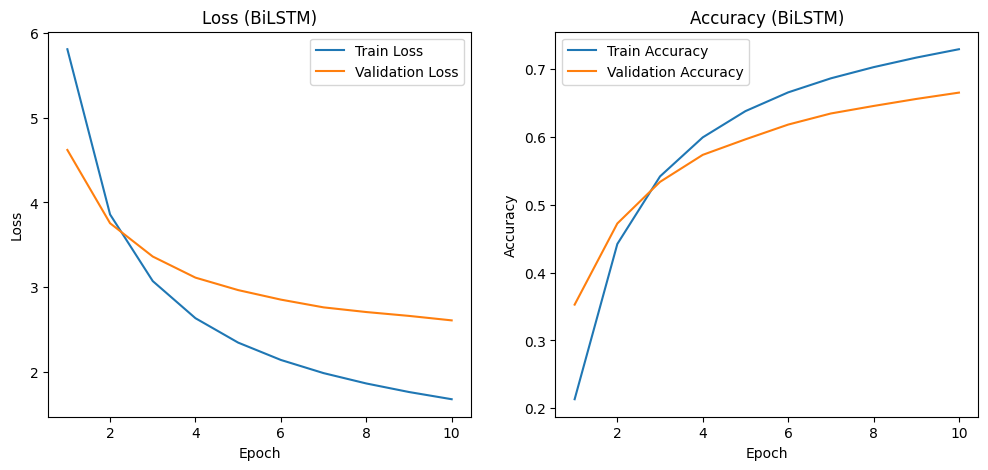

In [24]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (BiLSTM)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (BiLSTM)')
plt.legend()

plt.show()

In [25]:
# Lyrics prediction
def predict_song_title_L(text):
    model_L.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_L(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.cpu().numpy())
    return song_title[0]

def predict_song_title_T(text):
    model_T.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_T(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.numpy())
    return song_title[0]


def predict_song_title_C(text):
    model_C.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_C(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.numpy())
    return song_title[0]


def predict_song_title_G(text):
    model_G.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_G(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.numpy())
    return song_title[0]


def predict_song_title_B(text):
    model_B.eval()
    embedding = get_bert_embeddings(text).reshape(1, -1)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    with torch.no_grad():
        output = model_B(embedding)
        _, predicted = torch.max(output.data, 1)
        song_title = label_encoder.inverse_transform(predicted.numpy())
    return song_title[0]

L_predicted_song_title = predict_song_title_L(new_lyrics)
print(f'Predicted Song Title(LSTM): {L_predicted_song_title}')

T_predicted_song_title = predict_song_title_T(new_lyrics)
print(f'Predicted Song Title(Transformer): {T_predicted_song_title}')

C_predicted_song_title = predict_song_title_C(new_lyrics)
print(f'Predicted Song Title(CNN): {C_predicted_song_title}')

G_predicted_song_title = predict_song_title_G(new_lyrics)
print(f'Predicted Song Title(GRU): {G_predicted_song_title}')

B_predicted_song_title = predict_song_title_B(new_lyrics)
print(f'Predicted Song Title(BiLSTM): {B_predicted_song_title}')

# Input new lyrics (Title : 같은 하늘 다른 시간)
new_lyrics = """
물끄러미 바라본 저 하늘을
우리 같이 보고 있었나요
아스라이 잊어버린 시간을
우린 분명 알고 있었는데

모두가 그렇듯 우린 변한 게 없는데
지나가는 순간이 많아
결국 잊혀지겠지

오늘 보는 하늘은
특별한 모습일 거야
이대로 멈췄음 해
모든 게
흘러가도 다 느껴지지 않게

같은 하늘 다른 시간
"""

Predicted Song Title(LSTM): 힘든 건 사랑이 아니다
Predicted Song Title(Transformer): 봄날
Predicted Song Title(CNN): 힘든 건 사랑이 아니다
Predicted Song Title(GRU): 만남은 쉽고 이별은 어려워 (Feat. Leellamarz) (Prod. TOIL)
Predicted Song Title(BiLSTM): 힘든 건 사랑이 아니다
